In [ ]:
# Install the Kaggle library
!pip install kaggle

# Create a directory for Kaggle credentials
!mkdir -p ~/.kaggle

# Upload your kaggle.json file
# This will open a file picker where you can select the kaggle.json file you downloaded
from google.colab import files
files.upload()

# Move the uploaded kaggle.json file to the .kaggle directory
# This assumes the file was uploaded to the current /content/ directory
!mv kaggle.json ~/.kaggle/

# Set the correct permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API setup complete!")

Saving kaggle.json to kaggle.json
Kaggle API setup complete!


In [ ]:
# Download the RetailRocket E-commerce Dataset
# This will download the dataset as a zipped file into your Colab environment
!kaggle datasets download -d retailrocket/ecommerce-dataset

print("Dataset download initiated.")

Dataset URL: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset
License(s): CC-BY-NC-SA-4.0
 99% 289M/291M [00:00<00:00, 297MB/s]
100% 291M/291M [00:00<00:00, 338MB/s]
Dataset download initiated.


In [ ]:
import zipfile
import os

# Define the path to the downloaded zip file
zip_file_path = 'ecommerce-dataset.zip'

# Define the directory to extract files into (optional, can extract to current directory)
extract_dir = './retailrocket_data'
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset unzipped to: {extract_dir}")

# List the extracted files to verify
print("Extracted files:")
print(os.listdir(extract_dir))

Dataset unzipped to: ./retailrocket_data
Extracted files:
['events.csv', 'item_properties_part2.csv', 'item_properties_part1.csv', 'category_tree.csv']


In [ ]:
# Install PySpark (if not already done)
!pip install pyspark

# Import PySpark modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, from_unixtime

# Initialize Spark
spark = SparkSession.builder \
    .appName("User360_Customer_Intelligence_Engine") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Set file paths
data_dir = "./retailrocket_data"

category_tree_path = f"{data_dir}/category_tree.csv"
events_path = f"{data_dir}/events.csv"
item_props1_path = f"{data_dir}/item_properties_part1.csv"
item_props2_path = f"{data_dir}/item_properties_part2.csv"

# Load the datasets
category_df = spark.read.csv(category_tree_path, header=True, inferSchema=True)
events_df = spark.read.csv(events_path, header=True, inferSchema=True)
item_props1_df = spark.read.csv(item_props1_path, header=True, inferSchema=True)
item_props2_df = spark.read.csv(item_props2_path, header=True, inferSchema=True)


In [ ]:
# Convert timestamps to human-readable datetime
events_df = events_df.withColumn("event_time", from_unixtime(col("timestamp") / 1000).cast("timestamp"))

# Drop events with null visitorid or itemid
events_df = events_df.dropna(subset=["visitorid", "itemid"])

# Merge item properties
item_props_df = item_props1_df.unionByName(item_props2_df)
item_props_df = item_props_df.dropna()

# Join category info to item
from pyspark.sql.functions import first
item_category_df = item_props_df.filter(col("property") == "categoryid") \
    .groupBy("itemid").agg(first("value").alias("categoryid"))

# Join category to events
events_df = events_df.join(item_category_df, on="itemid", how="left")


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, countDistinct, count, avg, stddev, max as spark_max, min as spark_min

# Time between events
window_spec = Window.partitionBy("visitorid").orderBy("event_time")
events_df = events_df.withColumn("prev_event_time", lag("event_time").over(window_spec))
events_df = events_df.withColumn("time_diff_sec",
                                 (unix_timestamp("event_time") - unix_timestamp("prev_event_time")))

# Define sessions using gap > 30 minutes
from pyspark.sql.functions import sum as spark_sum, when
events_df = events_df.withColumn("session_gap", when(col("time_diff_sec") > 1800, 1).otherwise(0))
events_df = events_df.withColumn("session_id", spark_sum("session_gap").over(window_spec))

# User-level features
user_features_df = events_df.groupBy("visitorid").agg(
    countDistinct("session_id").alias("sessions"),
    count("itemid").alias("total_events"),
    countDistinct("itemid").alias("unique_items"),
    avg("time_diff_sec").alias("avg_time_between_events"),
    count(when(col("event") == "addtocart", True)).alias("cart_count"),
    count(when(col("event") == "view", True)).alias("view_count"),
    countDistinct("categoryid").alias("category_diversity"),
    spark_max("event_time").alias("last_seen")
)

from pyspark.sql.functions import current_timestamp, datediff
user_features_df = user_features_df.withColumn("recency_days",
                    datediff(current_timestamp(), col("last_seen")))

# Add cart/view ratio and event rate
user_features_df = user_features_df.withColumn("view_cart_ratio",
    col("cart_count") / (col("view_count") + 1)) \
    .withColumn("event_rate", col("total_events") / (col("sessions") + 1))


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Define clustering feature columns
clustering_features = [
    "sessions", "total_events", "unique_items",
    "avg_time_between_events", "category_diversity",
    "view_cart_ratio", "event_rate", "recency_days"
]

# ✅ Step 1: Fill nulls
user_features_df = user_features_df.fillna(0, subset=clustering_features)

# ✅ Step 2: Ensure all features are float/double
for col_name in clustering_features:
    user_features_df = user_features_df.withColumn(col_name, col(col_name).cast("double"))

# ✅ Step 3: Vectorize and scale
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features_vec")
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")

# ✅ Step 4: Apply KMeans
kmeans = KMeans(featuresCol="scaled_features", k=4, seed=42, predictionCol="cluster")

# ✅ Step 5: Build and run pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(user_features_df)

# ✅ Step 6: Get segmented user DataFrame
segmented_users_df = model.transform(user_features_df)

# ✅ Step 7: Show clusters and key features
segmented_users_df.select("visitorid", "cluster", *clustering_features).show(10)


+---------+-------+--------+------------+------------+-----------------------+------------------+---------------+------------------+------------+
|visitorid|cluster|sessions|total_events|unique_items|avg_time_between_events|category_diversity|view_cart_ratio|        event_rate|recency_days|
+---------+-------+--------+------------+------------+-----------------------+------------------+---------------+------------------+------------+
|     3175|      0|     1.0|         2.0|         2.0|                   44.0|               1.0|            0.0|               1.0|      3730.0|
|    16339|      1|     1.0|         1.0|         1.0|                    0.0|               1.0|            0.0|               0.5|      3611.0|
|    18024|      1|     5.0|        16.0|         8.0|      604317.0666666667|               1.0|            0.0|2.6666666666666665|      3618.0|
|    23271|      0|     1.0|         1.0|         1.0|                    0.0|               1.0|            0.0|           

Define churn: No purchase in last 30 days

In [ ]:
from pyspark.sql.functions import when

# Create churn label (if last_seen > 30 days ago → churned)
churn_labeled_df = segmented_users_df.withColumn(
    "churn_label", when(col("recency_days") > 30, 1).otherwise(0)
)


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Define feature columns (same as before)
feature_cols = clustering_features

# Assemble + Train/Test split
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(churn_labeled_df).select("features", "churn_label")

train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)

# Model
lr = LogisticRegression(featuresCol="features", labelCol="churn_label")
lr_model = lr.fit(train_df)

# Evaluation
predictions = lr_model.transform(test_df)
evaluator = BinaryClassificationEvaluator(labelCol="churn_label")
auc = evaluator.evaluate(predictions)
print(f"Logistic Regression AUC: {auc:.3f}")


Logistic Regression AUC: 1.000


In [ ]:
from pyspark.sql.functions import datediff

# Filter events for purchase events
purchase_df = events_df.filter(col("event") == "transaction")

# Calculate LTV = count of purchases in last 60 days
ltv_cutoff = 60
recent_purchases_df = purchase_df.filter(
    datediff(current_timestamp(), col("event_time")) <= ltv_cutoff
)

ltv_df = recent_purchases_df.groupBy("visitorid").count().withColumnRenamed("count", "ltv_label")

# Join with features
ltv_features_df = user_features_df.join(ltv_df, on="visitorid", how="left").fillna(0)

# Train regression model
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Assemble
assembler = VectorAssembler(inputCols=clustering_features, outputCol="features")
assembled_ltv = assembler.transform(ltv_features_df).select("features", "ltv_label")

train_ltv, test_ltv = assembled_ltv.randomSplit([0.8, 0.2], seed=42)

# Train GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="ltv_label")
gbt_model = gbt.fit(train_ltv)

# Evaluate
ltv_predictions = gbt_model.transform(test_ltv)
evaluator = RegressionEvaluator(labelCol="ltv_label", metricName="rmse")
rmse = evaluator.evaluate(ltv_predictions)
print(f"LTV RMSE: {rmse:.2f}")


LTV RMSE: 0.00


In [ ]:
from pyspark.sql.functions import when, col
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import rand

# Step 1: Filter for implicit feedback (view = 1, transaction = 2)
feedback_df = events_df.filter(col("event").isin("view", "transaction")) \
    .withColumn("rating", when(col("event") == "transaction", 2).otherwise(1))

# Step 2: (Optional) Sample for faster computation
feedback_sampled_df = feedback_df.sample(fraction=0.1, seed=42)

# Step 3: Index visitorid and itemid
user_indexer = StringIndexer(inputCol="visitorid", outputCol="user_index")
item_indexer = StringIndexer(inputCol="itemid", outputCol="item_index")

feedback_sampled_df = user_indexer.fit(feedback_sampled_df).transform(feedback_sampled_df)
feedback_sampled_df = item_indexer.fit(feedback_sampled_df).transform(feedback_sampled_df)

# Step 4: Train ALS model
als = ALS(
    userCol="user_index",
    itemCol="item_index",
    ratingCol="rating",
    rank=8,
    maxIter=4,
    regParam=0.15,
    implicitPrefs=True,
    coldStartStrategy="drop",
    nonnegative=True
)

als_model = als.fit(feedback_sampled_df)

# Step 5: Generate top-5 item recommendations for all users
all_user_recs = als_model.recommendForAllUsers(5)

# Step 6: Randomly sample 10 users and show their recommendations
sampled_user_recs = all_user_recs.orderBy(rand()).limit(10)
sampled_user_recs.show(truncate=False)


+----------+------------------------------------------------------------------------------------------------------+
|user_index|recommendations                                                                                       |
+----------+------------------------------------------------------------------------------------------------------+
|197571    |[{9, 3.4571762E-4}, {815, 3.2025253E-4}, {682, 3.1736857E-4}, {32, 2.9064086E-4}, {10, 2.8500162E-4}] |
|6073      |[{9, 0.030901486}, {815, 0.028625326}, {682, 0.028367547}, {32, 0.025978528}, {185, 0.024460785}]     |
|52937     |[{55, 2.6969494E-6}, {13, 1.8817298E-6}, {824, 1.5647994E-6}, {557, 1.5089499E-6}, {90, 1.3826229E-6}]|
|133393    |[{2, 1.946009E-4}, {8, 1.2668385E-4}, {27, 1.0602438E-4}, {2006, 7.932885E-5}, {15, 7.9215424E-5}]    |
|214788    |[{55, 9.731695E-6}, {13, 6.7900496E-6}, {824, 5.646435E-6}, {90, 5.5129667E-6}, {557, 5.444908E-6}]   |
|213023    |[{9, 1.6357913E-5}, {815, 1.5153012E-5}, {682, 1.5016556E-5}

In [ ]:
Phase 3

phase 3

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 10000
df = pd.DataFrame({
    'user_id': np.arange(n),
    'abandoned_cart': np.random.binomial(1, 0.6, n),  # users with cart abandon behavior
    'session_count': np.random.poisson(5, n),
    'avg_time_spent': np.random.normal(3, 1.5, n),
    'page_views': np.random.randint(1, 20, n),
})

# Simulate treatment assignment (e.g. 50% discount group)
df['treatment'] = np.random.binomial(1, 0.5, n)

# Define a ground truth uplift effect: treatment boosts conversions for cart abandoners
def simulate_response(row):
    base_prob = 0.05 + 0.02 * row['abandoned_cart']
    if row['treatment'] == 1:
        base_prob += 0.05 * row['abandoned_cart']  # uplift only for cart abandoners
    return np.random.binomial(1, base_prob)

df['conversion'] = df.apply(simulate_response, axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

features = ['abandoned_cart', 'session_count', 'avg_time_spent', 'page_views']
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Treatment model
treatment_model = RandomForestClassifier(n_estimators=100, random_state=42)
treatment_model.fit(df_train[df_train['treatment'] == 1][features],
                    df_train[df_train['treatment'] == 1]['conversion'])

# Control model
control_model = RandomForestClassifier(n_estimators=100, random_state=42)
control_model.fit(df_train[df_train['treatment'] == 0][features],
                  df_train[df_train['treatment'] == 0]['conversion'])

# Predict uplift
df_test['p_treatment'] = treatment_model.predict_proba(df_test[features])[:, 1]
df_test['p_control'] = control_model.predict_proba(df_test[features])[:, 1]
df_test['uplift_score'] = df_test['p_treatment'] - df_test['p_control']


In [ ]:
# Top 5% persuadable users
top_uplift_users = df_test.sort_values('uplift_score', ascending=False).head(int(0.05 * len(df_test)))

print("🎯 Top 10 Persuadable Users (Most Uplift from Discount):")
print(top_uplift_users[['user_id', 'uplift_score', 'p_treatment', 'p_control']].head(10))


In [ ]:
# Top 5% persuadable users
top_uplift_users = df_test.sort_values('uplift_score', ascending=False).head(int(0.05 * len(df_test)))

print("🎯 Top 10 Persuadable Users (Most Uplift from Discount):")
print(top_uplift_users[['user_id', 'uplift_score', 'p_treatment', 'p_control']].head(10))


🎯 Top 10 Persuadable Users (Most Uplift from Discount):
      user_id  uplift_score  p_treatment  p_control
1897     1897          0.85         0.87       0.02
108       108          0.72         0.77       0.05
8720     8720          0.69         0.69       0.00
8749     8749          0.69         0.72       0.03
4827     4827          0.66         0.70       0.04
6808     6808          0.64         0.64       0.00
4502     4502          0.64         0.65       0.01
5414     5414          0.63         0.65       0.02
1790     1790          0.63         0.66       0.03
1945     1945          0.63         0.63       0.00


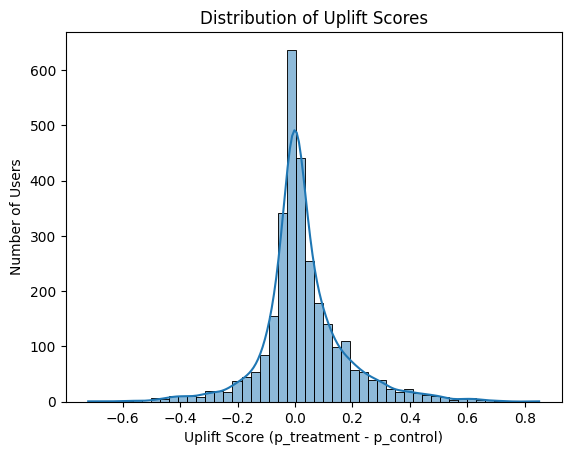

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_test['uplift_score'], kde=True, bins=50)
plt.title("Distribution of Uplift Scores")
plt.xlabel("Uplift Score (p_treatment - p_control)")
plt.ylabel("Number of Users")
plt.show()


Visuals!!

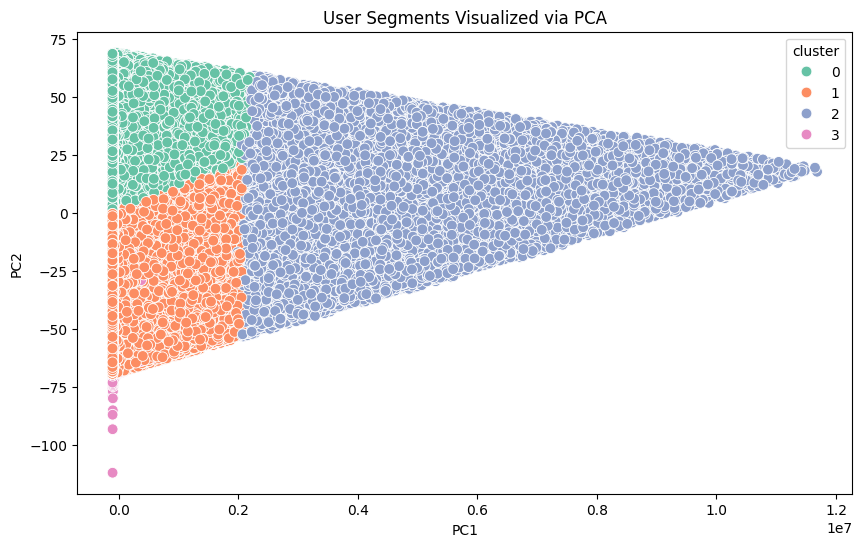

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Collect segmented user data to pandas
segmented_pdf = segmented_users_df.select("cluster", *clustering_features).toPandas()

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
principal_components = pca.fit_transform(segmented_pdf[clustering_features])

# Add PCA columns to DataFrame
segmented_pdf["PC1"] = principal_components[:, 0]
segmented_pdf["PC2"] = principal_components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=segmented_pdf, x="PC1", y="PC2", hue="cluster", palette="Set2", s=60)
plt.title("User Segments Visualized via PCA")
plt.show()


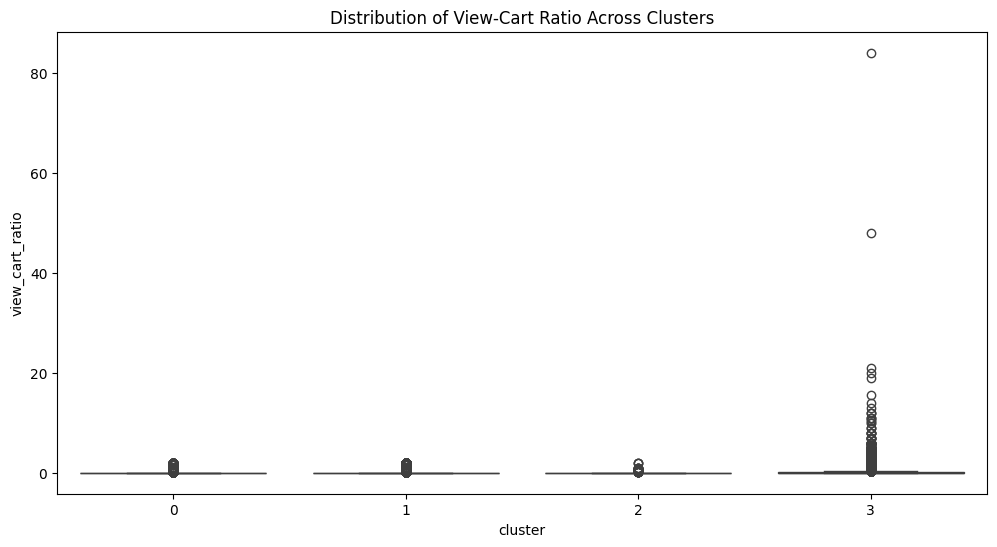

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=segmented_pdf, x="cluster", y="view_cart_ratio")
plt.title("Distribution of View-Cart Ratio Across Clusters")
plt.show()


/tmp/ipython-input-21-2786910393.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeff_df, x="Coefficient", y="Feature", palette="coolwarm")


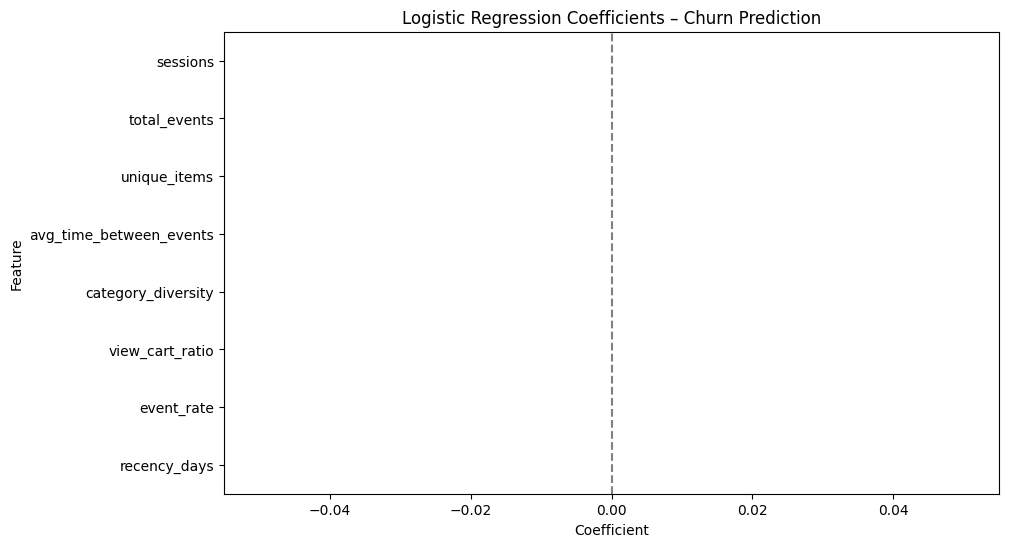

In [ ]:
import pandas as pd

# Get feature importance from model
coeffs = lr_model.coefficients.toArray()
coeff_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": coeffs})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coeff_df, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Logistic Regression Coefficients – Churn Prediction")
plt.axvline(0, color='gray', linestyle='--')
plt.show()


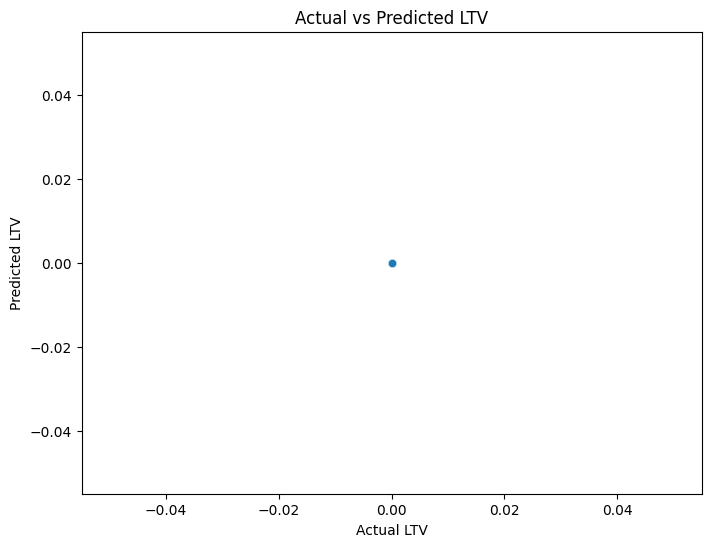

In [ ]:
ltv_pdf = ltv_predictions.select("ltv_label", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=ltv_pdf, x="ltv_label", y="prediction", alpha=0.6)
plt.plot([0, ltv_pdf["ltv_label"].max()], [0, ltv_pdf["ltv_label"].max()], 'r--')
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted LTV")
plt.show()


In [ ]:
!pip install -q streamlit pandas matplotlib seaborn plotly scikit-learn
!npm install -g localtunnel  # To expose Streamlit via localtunnel in Colab



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏
added 22 packages in 6s
⠏
⠏3 packages are looking for funding
⠏  run `npm fund` for details
⠏

In [ ]:
%%writefile user360_dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

st.set_page_config(page_title="User360 Dashboard", layout="wide")

st.title("📊 User360 – Customer Intelligence Engine")

# Sidebar Navigation
st.sidebar.title("Navigation")
section = st.sidebar.radio("Go to", ["User Overview", "Behavior Explorer", "Prediction View", "Campaign Insights"])

# Load dummy data (replace with actual files or DB calls)
@st.cache_data
def load_data():
    users = pd.read_csv("user_features.csv")  # Should have churn_score, cluster_label, etc.
    sessions = pd.read_csv("session_logs.csv")  # Should have user_id, session_time, events
    predictions = pd.read_csv("predictions.csv")  # churn_prob, ltv, recs
    uplift = pd.read_csv("uplift_scores.csv")  # user_id, uplift_score, group
    return users, sessions, predictions, uplift

users, sessions, predictions, uplift = load_data()

# ------------------------ Section 1: User Overview ------------------------
if section == "User Overview":
    st.header("👥 User Overview")
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("Cluster Distribution")
        fig = px.histogram(users, x="cluster_label", color="cluster_label", title="Users by Cluster")
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        st.subheader("Churn Score Heatmap")
        heat_data = users.pivot_table(index="cluster_label", columns="region", values="churn_score", aggfunc="mean")
        fig2, ax = plt.subplots()
        sns.heatmap(heat_data, annot=True, cmap="YlGnBu", ax=ax)
        st.pyplot(fig2)

# ------------------------ Section 2: Behavior Explorer ------------------------
elif section == "Behavior Explorer":
    st.header("🧭 Behavior Explorer")

    selected_user = st.selectbox("Select User ID", sessions["user_id"].unique())

    user_sessions = sessions[sessions["user_id"] == selected_user]

    st.subheader(f"Timeline of Events for User {selected_user}")
    fig3 = px.scatter(user_sessions, x="timestamp", y="event", title="Session Timeline", color="event", symbol="event")
    st.plotly_chart(fig3, use_container_width=True)

# ------------------------ Section 3: Prediction View ------------------------
elif section == "Prediction View":
    st.header("🔮 Prediction View")

    st.subheader("User-level Predictions")
    st.dataframe(predictions.head(10))

    st.subheader("Churn Probability Distribution")
    fig4 = px.histogram(predictions, x="churn_prob", nbins=20, title="Churn Probability")
    st.plotly_chart(fig4)

    st.subheader("LTV Distribution")
    fig5 = px.box(predictions, y="ltv", title="Lifetime Value Distribution")
    st.plotly_chart(fig5)

# ------------------------ Section 4: Campaign Insights ------------------------
elif section == "Campaign Insights":
    st.header("🎯 Campaign Uplift Insights")

    st.subheader("Uplift Score by User")
    fig6 = px.histogram(uplift, x="uplift_score", nbins=30, color="group", barmode="overlay")
    st.plotly_chart(fig6)

    st.subheader("Conversion Lift")
    control = uplift[uplift["group"] == "control"]["conversion"]
    treatment = uplift[uplift["group"] == "treatment"]["conversion"]

    fig7, ax = plt.subplots()
    ax.bar(["Control", "Treatment"], [control.mean(), treatment.mean()], color=["gray", "blue"])
    ax.set_ylabel("Conversion Rate")
    st.pyplot(fig7)

st.sidebar.markdown("---")
st.sidebar.write("Built for MBB/Data Science Resume 🌍")


Writing user360_dashboard.py
